In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf

In [2]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans


In [3]:
# Build a SparkSession named as "test123"
spark = SparkSession.builder \
    .appName('test_123') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

## Loading the Data

In [4]:
paps = spark.read.json("../data/processed/dummy.json/")

In [5]:
#Adding an ID to each paper so the abstract data analysis can be attributed to a paper
from pyspark.sql.functions import monotonically_increasing_id
papersWIDs = paps.withColumn("id", monotonically_increasing_id())

## Clustering

In [6]:
cols = papersWIDs.columns
cols.remove("title")
cols.remove("id")
cols

['CERN_LHC_Coll',
 'GeV',
 'None',
 'anomaly',
 'background',
 'dark_matter',
 'dark_matter__mass',
 'effective_field_theory',
 'heavy_ion__scattering',
 'higher-order__1',
 'kinematics',
 'lattice',
 'lattice_field_theory',
 'new_physics',
 'num_refs',
 'number_of_pages',
 'numerical_calculations',
 'p_p__scattering',
 'quantum_chromodynamics',
 'quark',
 'sensitivity',
 'stability',
 'structure']

In [7]:
from pyspark.ml.feature import MinMaxScaler, StandardScaler

In [8]:
# remving nans
print(papersWIDs.count())
papersWIDs_woNA = papersWIDs.dropna()
print(papersWIDs_woNA.count())

3000
2931


In [9]:
assembler = VectorAssembler().setInputCols(cols).setOutputCol("features")
transformed_data = assembler.transform(papersWIDs_woNA)

In [10]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [11]:
scale_model  = scaler.fit(transformed_data)
scaled_data = scale_model.transform(transformed_data)

In [12]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
metric_name = 'silhouette'
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaledFeatures', \
                                metricName=metric_name, distanceMeasure='squaredEuclidean')
scores = dict()
for i in range(2, 50):
    kmeans_algo = KMeans(featuresCol="scaledFeatures", k=i)
    kmeans_fit = kmeans_algo.fit(scaled_data)
    kmeans_out = kmeans_fit.transform(scaled_data)
    score = evaluator.evaluate(kmeans_out)
    print(i, " ", score)
    scores[i] = score

2   0.31171283307325753
3   0.36337193889830616
4   0.3505639559232367
5   0.35417628157998543
6   0.3172577733195148
7   0.4175981626890465
8   0.3621057565974049
9   0.4127045098936312
10   0.3930504357252089
11   0.42147137641175975
12   0.40305066576142745
13   0.4249342908006864
14   0.44120073361878126
15   0.41929668293581807
16   0.4075873124194317
17   0.4528862070670651
18   0.3697491019968808
19   0.48796744942576475
20   0.49563598688047145
21   0.4652020664392432
22   0.527618858873529
23   0.5396158916118104
24   0.1850686930283723
25   0.5911809850326091
26   0.560351830178031
27   0.5842497886083827
28   0.5511737635382405
29   0.6159950776590379
30   0.5966262969280086
31   0.5913139971524937
32   0.5903511690312329
33   0.5893895403857907
34   0.367419262331317
35   0.6163393140984773
36   0.5924997805095742
37   0.613680053856136
38   0.5728253434560984
39   0.6137343493816658
40   0.5621350468097509
41   0.646970663640051
42   0.5493832303139216
43   0.4781937716951

In [13]:
import matplotlib.pyplot as plt

In [14]:
import numpy as np

In [15]:
scores_array = np.array([[k, scores[k]] for k in scores.keys()])

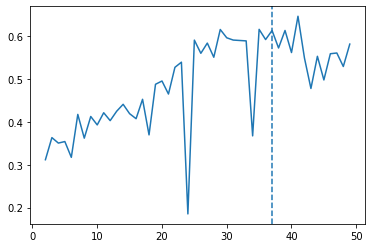

In [16]:
plt.plot(scores_array[:,0], scores_array[:,1])
plt.axvline(x=37, linestyle = '--')

### Stability

In [117]:
def extract_cluster(preds = None, k = 37, data = scaled_data, seed=1, no_cl=0):
    if not preds:
        preds = KMeans(featuresCol="scaledFeatures", k=k, seed=seed).\
            fit(data).\
            transform(scaled_data).select("id", "prediction")
    sorted_preds = preds.groupby("prediction").count().sort(desc("count"))
    gr = preds.filter(preds["prediction"] == sorted_preds.take(no_cl+1)[no_cl][0]).select("id").collect()
    gr = [g[0] for g in gr]
    return set(gr)

In [154]:
i1, i2 = 10, 4
no_cl = 19
k = 20
s1 = extract_cluster(seed = i1, no_cl = no_cl, k=k)
s2 = extract_cluster(seed = i2, no_cl = no_cl, k=k)
print("[s1]=", len(s1))
print("[s2]=", len(s2))
print("[s1*s2]=", len( s1.intersection(s2)))
print("kappa = ", len(s1.intersection(s2))/np.min( [len(s1), len(s2)]))

[s1]= 11
[s2]= 20
[s1*s2]= 0
kappa =  0.0
